In [1]:
import sys
import numpy as np
import spectral as sp
import matplotlib as mpl
import matplotlib.pyplot as plt

sys.path.append('../')
from preprocessing import *
from extinctions import *
from plotting_parameters import *

/home/martin_ivan/anaconda3/envs/thesis/lib/python3.10/site-packages/spectral/io/envi.py:175: UserWarning: Parameters with non-lowercase names encountered and converted to lowercase. To retain source file parameter name capitalization, set spectral.settings.envi_support_nonlowercase_params to True.
  warnings.warn(msg)


(<Figure size 500x500 with 1 Axes>, <Axes: >)

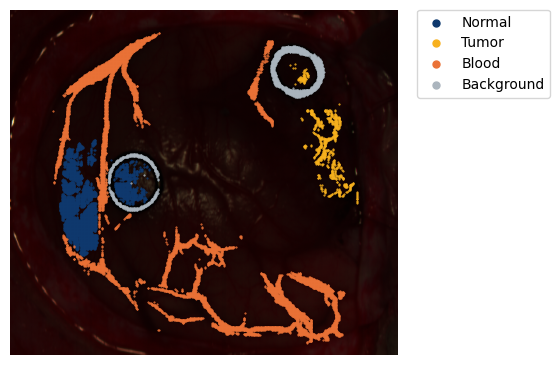

In [2]:
data_folder = "../../datasets/helicoid/012-01"
class_labels = ["Not labled", "Normal", "Tumor", "Blood", "Background"]
class_colors = ["white", tum_blue_dark_2, tum_orange, tum_red, tum_grey_5]

# Load the sp data
img = sp.open_image(data_folder + "/raw.hdr")
white_ref = sp.open_image(data_folder + "/whiteReference.hdr")
dark_ref = sp.open_image(data_folder + "/darkReference.hdr")
gt_map = sp.open_image(data_folder + "/gtMap.hdr")

plot_img(img, gt_map, class_labels, class_colors, figsize=(5,5), legend=True)

In [3]:
img_data = get_array(img)
img_data = img_data.astype(np.float32)
img_data_norm = img_data / np.linalg.norm(img_data, axis=(0,1), keepdims=True)

img_data_proj = project_img(img_data, white_ref, dark_ref)

In [4]:
from scipy.ndimage import sobel, gaussian_filter
from skimage import filters

def structure_tensor_mag_dir(fx, fy, sigma):
    fxfx = np.einsum('ijk,ijk->ij', fx, fx)
    fxfy = np.einsum('ijk,ijk->ij', fx, fy)
    fyfy = np.einsum('ijk,ijk->ij', fy, fy)

    # compute entries of the structure tensor G = [gxx, gxy; gxy, gyy]
    gxx = gaussian_filter(fxfx, sigma=sigma)
    gxy = gaussian_filter(fxfy, sigma=sigma)
    gyy = gaussian_filter(fyfy, sigma=sigma)

    # compute eigenvalues of the structure tensor
    lambda1 = 0.5*(gxx + gyy + np.sqrt((gxx-gyy)**2 + 4*gxy**2))
    # lambda2 = 0.5*(gxx + gyy - np.sqrt((gxx-gyy)**2 + 4*gxy**2))

    eps = 1e-8
    magnitude = np.sqrt(lambda1**2) + eps
    direction = 0.5* np.arctan2(2*gxy, gxx-gyy)

    return magnitude, direction


def nonmaxsupress(Gm, Gd, th=1000):
    nms = np.zeros(Gm.shape, Gm.dtype) + 1e-8   
    h,w = Gm.shape    
    for x in range(1, w-1):
        for y in range(1, h-1):            
            mag = Gm[y,x]
            # if mag < th: continue        
            teta = Gd[y,x]            
            dx, dy = 0, -1      # abs(orient) >= 1.1781, teta < -67.5 degrees and teta > 67.5 degrees
            if abs(teta) <= 0.3927: dx, dy = 1, 0       # -22.5 <= teta <= 22.5
            elif teta < 1.1781 and teta > 0.3927: dx, dy = 1, 1     # 22.5 < teta < 67.5 degrees
            elif teta > -1.1781 and teta < -0.3927: dx, dy = 1, -1  # -67.5 < teta < -22.5 degrees            
            if mag > Gm[y+dy,x+dx] and mag > Gm[y-dy,x-dx]: nms[y,x] = mag    
    return nms

In [5]:
fx = sobel(img_data_norm, axis=1)
fy = sobel(img_data_norm, axis=0)

sigma = 0.5
magnitude, direction = structure_tensor_mag_dir(fx, fy, sigma)

nms = nonmaxsupress(magnitude, direction, th=0.1)

In [6]:
fx = sobel(img_data_norm, axis=1)
fy = sobel(img_data_norm, axis=0)

f = img_data_norm
f_hat = f / np.linalg.norm(f, axis=2, keepdims=True)
Sx = fx - (fx * f_hat) * f_hat
sx = Sx / np.linalg.norm(f, axis=2, keepdims=True)
Sy = fy - (fx * f_hat) * f_hat
sy = Sy / np.linalg.norm(f, axis=2, keepdims=True)

sigma = 0.5
magnitude_s, direction_s = structure_tensor_mag_dir(sx, sy, sigma)

nms_s = nonmaxsupress(magnitude_s, direction_s, th=0.1)

In [7]:
fx_p = sobel(img_data_proj, axis=1)
fy_p = sobel(img_data_proj, axis=0)

sigma = 0.5
magnitude_p, direction_p = structure_tensor_mag_dir(fx_p, fy_p, sigma)

nms_p = nonmaxsupress(magnitude_p, direction_p, th=0.1)

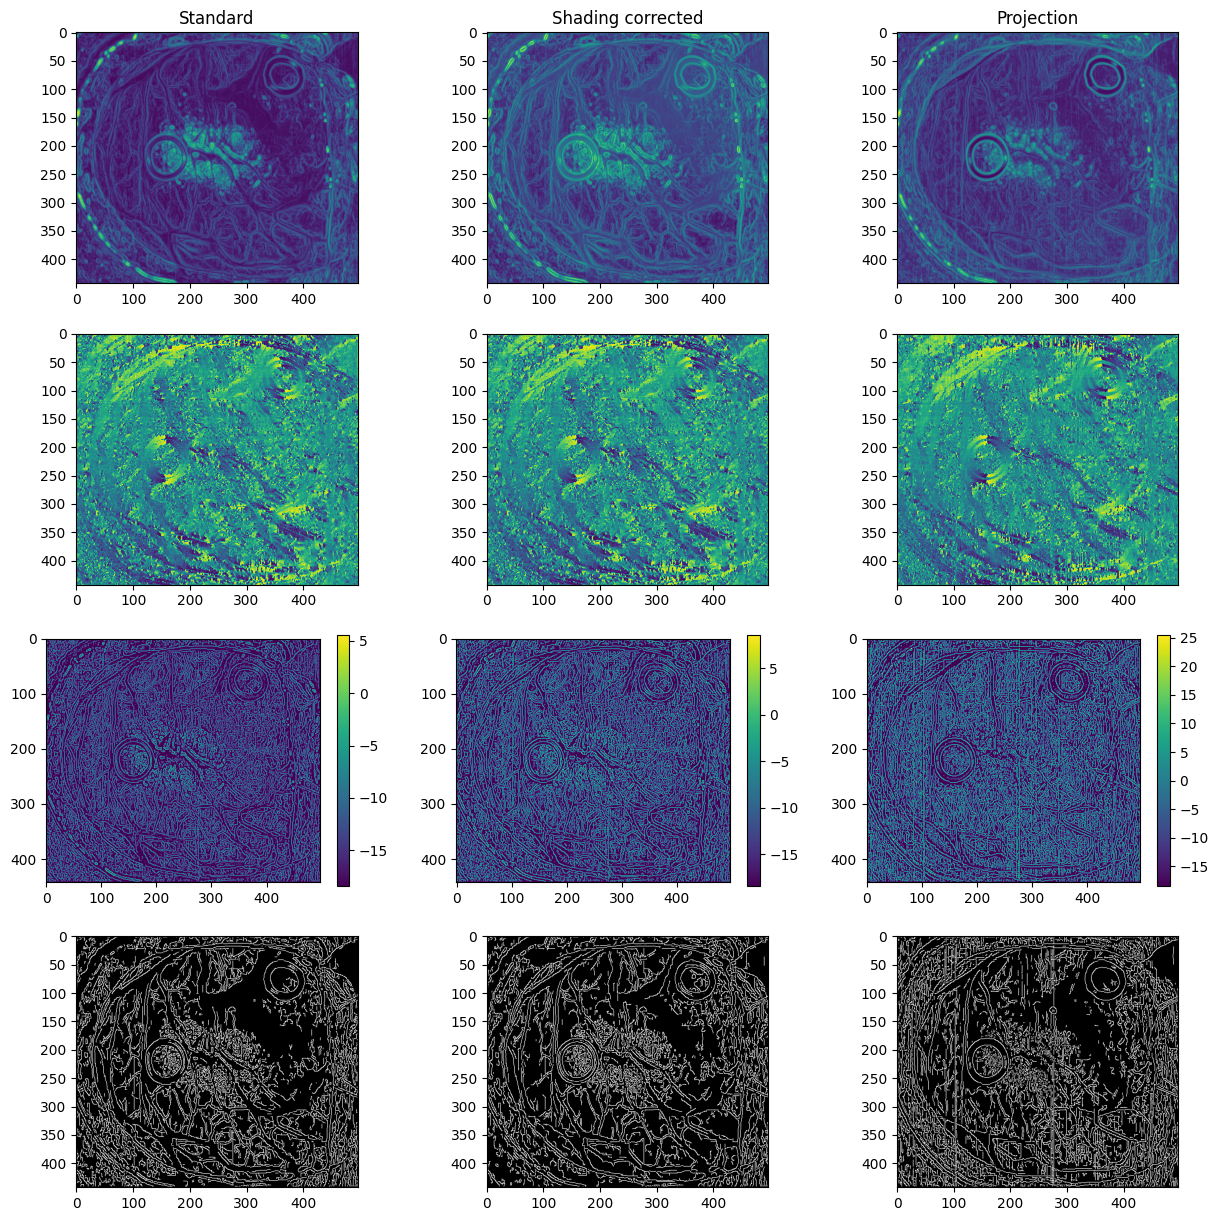

In [8]:
sigma = 0.1
magnitude, direction = structure_tensor_mag_dir(fx, fy, sigma)
nms = nonmaxsupress(magnitude, direction, th=0.1)
edges = filters.apply_hysteresis_threshold(nms, 0.004, 0.009)

magnitude_s, direction_s = structure_tensor_mag_dir(sx, sy, sigma)
nms_s = nonmaxsupress(magnitude_s, direction_s, th=0.1)
edges_s = filters.apply_hysteresis_threshold(nms_s, 1, 4)

magnitude_p, direction_p = structure_tensor_mag_dir(fx_p, fy_p, sigma)
nms_p = nonmaxsupress(magnitude_p, direction_p, th=0.1)
edges_p = filters.apply_hysteresis_threshold(nms_p, 8000000, 17000000)


fig, axs = plt.subplots(4, 3, figsize=(15,15))
axs[0,0].imshow(np.log(magnitude))
axs[0,0].set_title("Standard")
axs[0,1].imshow(np.log(magnitude_s))
axs[0,1].set_title("Shading corrected")
axs[0,2].imshow(np.log(magnitude_p))
axs[0,2].set_title("Projection")
axs[1,0].imshow(direction)
axs[1,1].imshow(direction_s)
axs[1,2].imshow(direction_p)

img_nms = axs[2,0].imshow(np.log(nms))
fig.colorbar(img_nms, ax=axs[2,0])
img_nms_s = axs[2,1].imshow(np.log(nms_s))
fig.colorbar(img_nms_s, ax=axs[2,1])
img_nms_p = axs[2,2].imshow(np.log(nms_p))
fig.colorbar(img_nms_p, ax=axs[2,2])

axs[3,0].imshow(edges, cmap='gray')
axs[3,1].imshow(edges_s, cmap='gray')
axs[3,2].imshow(edges_p, cmap='gray')

# save as svg   
fig.savefig("edge_detection.svg", format="svg", bbox_inches='tight')